In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()
from Bio.pairwise2 import format_alignment
from prody import *

print('Done with initial import')

from data_processing import pdb2msa, data_processing_pdb2msa

import ecc_tools as tools

Done with initial import


In [2]:
create_new = False
printing = True
removing_cols = True
remove_diagonals = False

data_path = Path('/data/cresswellclayec/DCA_ER/Pfam-A.full')
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir


pdb_path = "/pdb/pdb/"
dir_path = "/data/cresswellclayec/DCA_ER/biowulf_full/protein_data/di/"

ER_result = list(Path(dir_path).rglob("*ER_di.npy"))
ER_di_pdb_list = [str(path)[-22:-18] for path in ER_result]
ER_di_pfam_list = [str(path)[-17:-10] for path in ER_result]
ER_pdb_path_str = ['%s%s/pdb%s.ent.gz' % (pdb_path, pdb[1:3], pdb) for pdb in ER_di_pdb_list]
print('ER di: ', len(ER_di_pdb_list))
print(ER_di_pdb_list[:5])
print(ER_di_pfam_list[:5])

# # Load other method results to get intersection set
# PLM_result = list(Path(dir_path).rglob("*PLM_di.npy"))
# PLM_di_pdb_list = [str(path)[-23:-19] for path in PLM_result]
# PLM_di_pfam_list = [str(path)[-18:-13] for path in PLM_result]
# PLM_pdb_path_str = ['%s%s/pdb%s.ent.gz' % (pdb_path, pdb[1:3], pdb) for pdb in PLM_di_pdb_list]
# print('PLM di: ', len(PLM_di_pdb_list))
# print(PLM_di_pdb_list[:5])
# print(PLM_di_pfam_list[:5])

# PMF_result = list(Path(dir_path).rglob("*PMF_di.npy"))
# PMF_di_pdb_list = [str(path)[-23:-19] for path in PMF_result]
# PMF_di_pfam_list = [str(path)[-18:-13] for path in PMF_result]
# PMF_pdb_path_str = ['%s%s/pdb%s.ent.gz' % (pdb_path, pdb[1:3], pdb) for pdb in PMF_di_pdb_list]
# print('PMF di: ', len(PMF_di_pdb_list))
# print(PMF_di_pdb_list[:5])
# print(PMF_di_pfam_list[:5], '\n\n')


# comparison_pdb_str_set = set.intersection (set(ER_di_pdb_list), set(PLM_di_pdb_list), set(PMF_di_pdb_list))
# print(len(comparison_pdb_str_set))
# # print(comparison_pdb_str_set)
# pdb_comparison_paths = ['%s%s/pdb%s.ent.gz' % (pdb_path,  pdb[1:3], pdb) for pdb in comparison_pdb_str_set]


ER di:  53031
['5zec', '6i6k', '5pxj', '3ej8', '2cui']
['PF01073', 'PF00891', 'PF00439', 'PF02898', 'PF00041']


In [10]:
MSA_sizes = []
n_cols = []
n_seqs = []
dims = []
for i, pdb_id in enumerate(ER_di_pdb_list):
    pfam_id = ER_di_pfam_list[i]
    try:
        
        MSA_file = "%s/%s_%s_preproc_msa.npy" % (processed_data_dir, pfam_id, pdb_id)
        MSA = np.load(MSA_file)
 
        # # pfam_dimensions created in run_auc_allMethods.py during creation of auc curves for all methods.
#         pfam_dimensions_file = "%s/%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
#         pfam_dimensions = np.load(pfam_dimensions_file)
        

    except(FileNotFoundError):
        continue

    
    MSA_sizes.append(MSA.shape)
#     if len(pfam_dimensions)==7:
#         [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
#     elif len(pfam_dimensions)==3:
#         [n_col, n_seq, m_eff] = pfam_dimensions
    n_col = MSA.shape[1]
    n_seq = MSA.shape[0]
    n_cols.append(n_col)
    n_seqs.append(n_seq)
    dims.append(n_col * n_seq)
print(len(dims))

53030


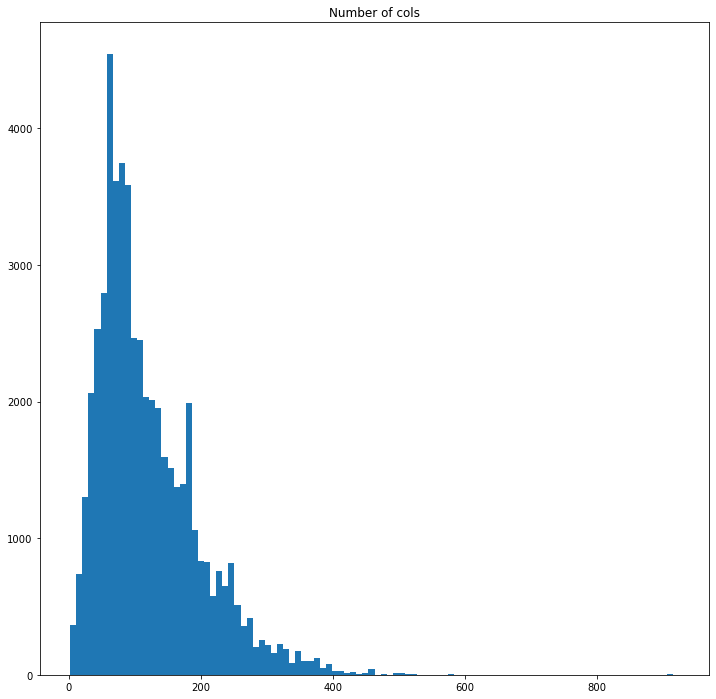

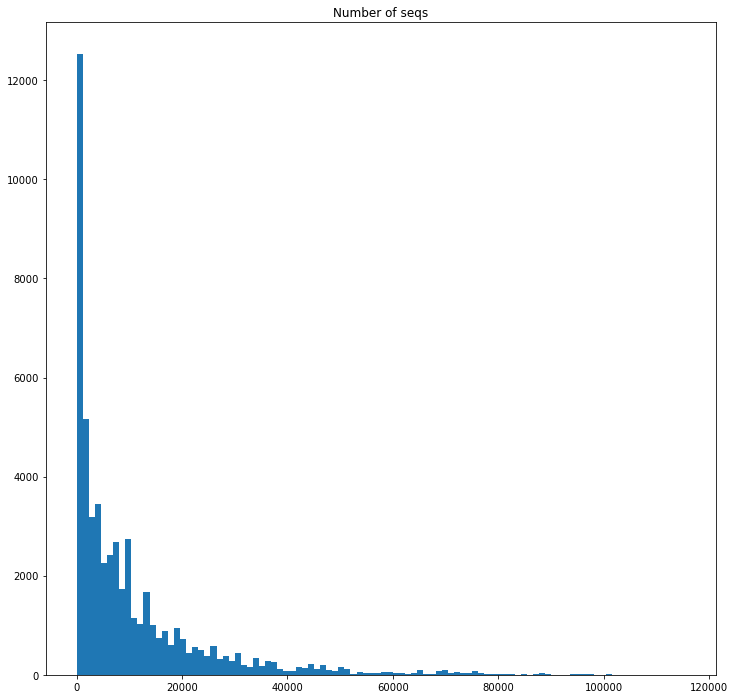

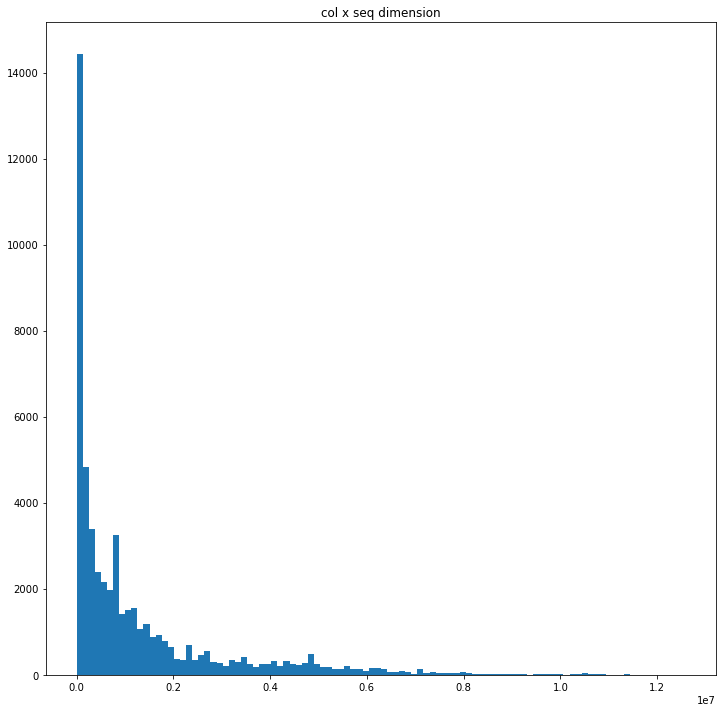

In [13]:
col_file = "%s/msa_ncols.npy" % processed_data_dir
np.save(col_file, n_cols)
seq_file = "%s/msa_nsequences.npy" % processed_data_dir
np.save(seq_file, n_seqs)
dim_file = "%s/msa_dimensions.npy" % processed_data_dir
np.save(dim_file, dims)

plt.figure(figsize=(12.0,12))
plt.hist(n_cols,  bins=100)  # density=False would make counts
plt.title('Number of cols')
plt.savefig('numCol_hist.pdf')

plt.figure(figsize=(12.0,12))
plt.hist(n_seqs,  bins=100)  # density=False would make counts
plt.title('Number of seqs')
plt.savefig('numSeq_hist.pdf')

plt.figure(figsize=(12.0,12))
plt.hist(dims,  bins=100)  # density=False would make counts
plt.title('col x seq dimension')
plt.savefig('dim_hist.pdf')


print('max pfam and pdb id with dim n_col, n_seq, dim:\n',)